In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [25]:
retail = pd.read_csv("OnlineRetail.csv",encoding="ISO-8859-1")
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [26]:
retail.shape

(541909, 8)

In [27]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [28]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [29]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [30]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [31]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

In [32]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [33]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [34]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [35]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [36]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [37]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [38]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [39]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [40]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

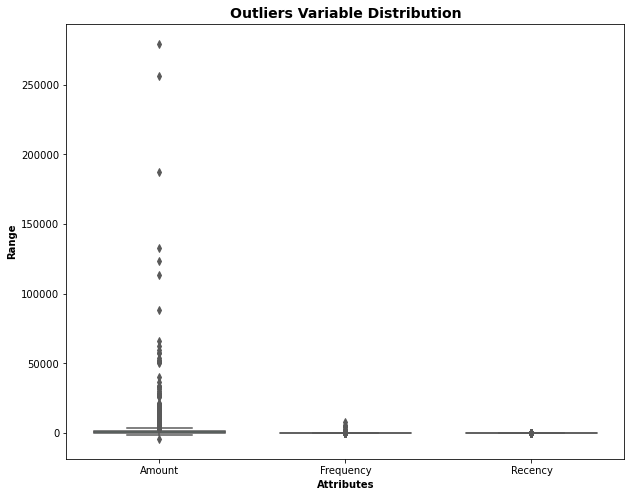

In [41]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']

sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [42]:
rfm.describe()

,Amount,Frequency,Recency
count,4372.000000,4372.000000,4372.000000
mean,1898.459701,93.053294,91.047118
std,8219.345141,232.471608,100.765435
min,-4287.630000,1.000000,0.000000
25%,293.362500,17.000000,16.000000
50%,648.075000,42.000000,49.000000
75%,1611.725000,102.000000,142.000000
max,279489.020000,7983.000000,373.000000


In [43]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [44]:
rfm.describe()

,Amount,Frequency,Recency
count,4293.000000,4293.000000,4293.000000
mean,1270.411464,77.483578,92.548567
std,1755.551155,100.270448,101.006845
min,-4287.630000,1.000000,0.000000
25%,289.360000,17.000000,17.000000
50%,632.970000,40.000000,50.000000
75%,1518.430000,97.000000,145.000000
max,13677.590000,718.000000,373.000000


In [47]:
rfm.shape

(4293, 4)

Text(0.5, 0, 'Attributes')

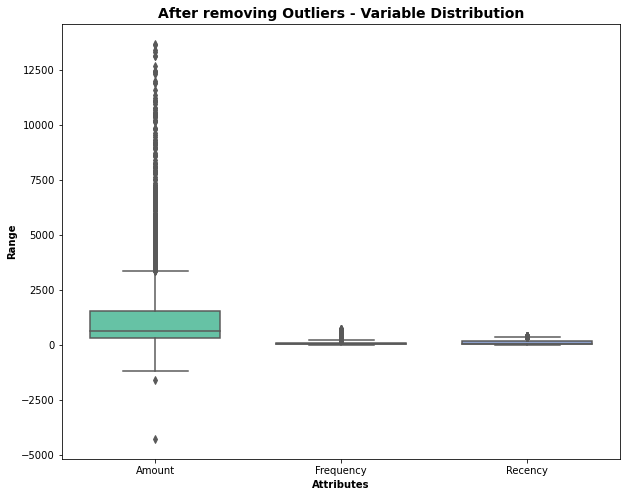

In [46]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']

sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("After removing Outliers - Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [23]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [48]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [49]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [50]:
kmeans.labels_

array([0, 3, 1, ..., 0, 1, 1])

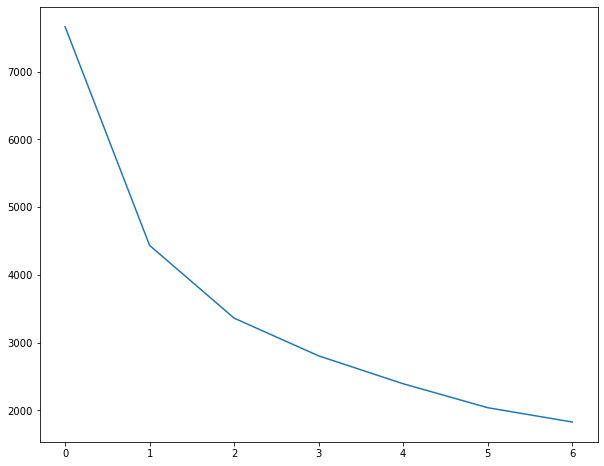

In [51]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [52]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4777820100216849
For n_clusters=5, the silhouette score is 0.46464537019783203
For n_clusters=6, the silhouette score is 0.41773142554966397
For n_clusters=7, the silhouette score is 0.4181795595993172
For n_clusters=8, the silhouette score is 0.3879594558057553


In [53]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [54]:
 kmeans.labels_

array([0, 1, 2, ..., 0, 2, 2])

In [55]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

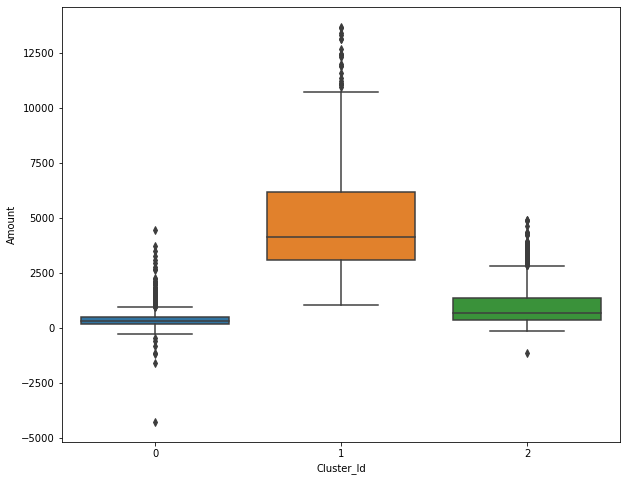

In [56]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

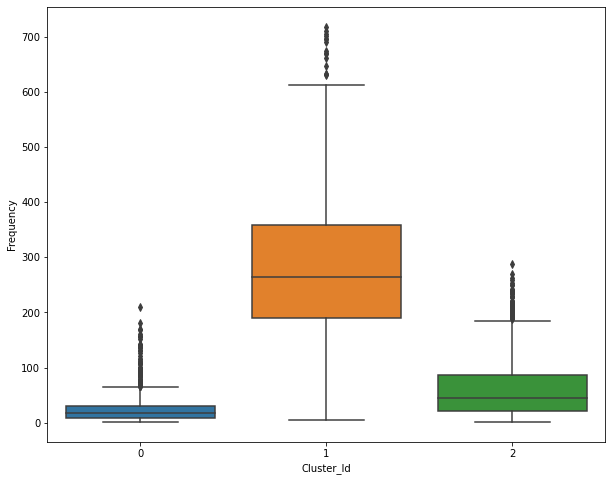

In [57]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

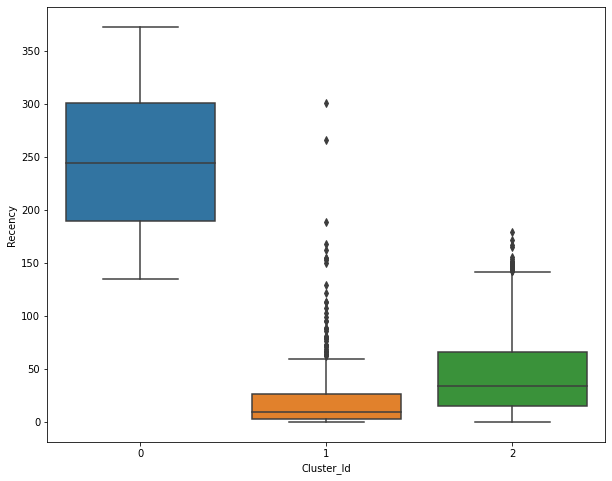

In [58]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

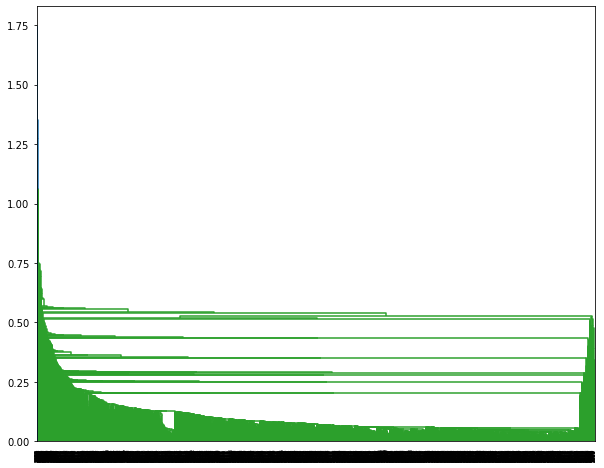

In [59]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

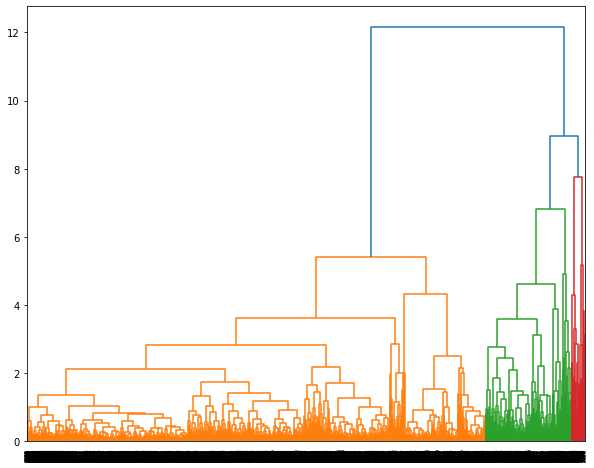

In [60]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

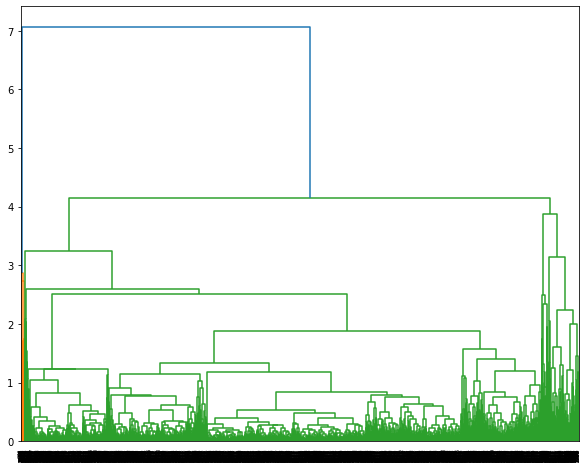

In [61]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [63]:
#Below is for assigning cluster lables

# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,0,0


<AxesSubplot:xlabel='Cluster_Labels', ylabel='Amount'>

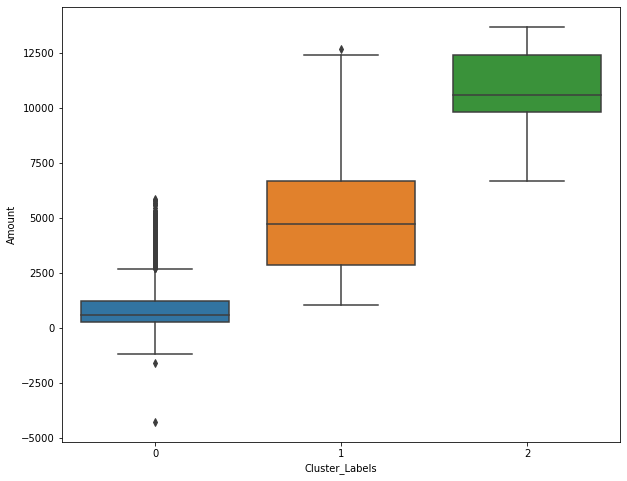

In [65]:
# Plot Cluster Labels vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Frequency'>

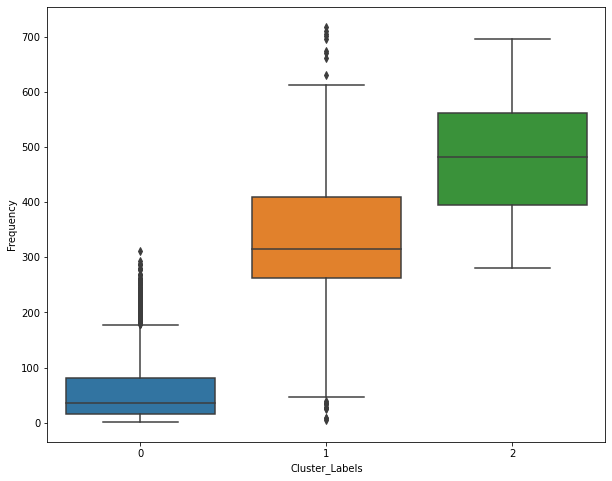

In [66]:
# Plot Cluster Labels vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Recency'>

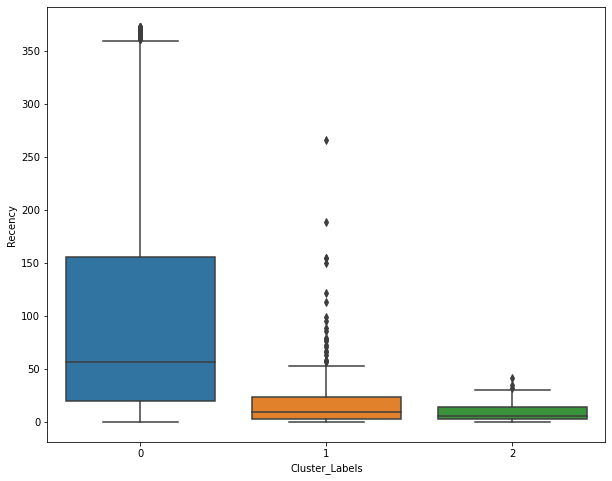

In [67]:
# Plot Cluster Labels vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

In [69]:
#Inference:
#K-Means Clustering with 3 Cluster Ids

#Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
#Customers with Cluster Id 1 are frequent buyers.
#Customers with Cluster Id 0 are not recent buyers and hence least of importance from business point of view.
#Hierarchical Clustering with 3 Cluster Labels

#Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
#Customers with Cluster_Labels 2 are frequent buyers.
#Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.